In [1]:
# !wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

In [2]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split

df = pd.read_csv("course_lead_scoring.csv")
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [12]:
categorical = [col for col in df.columns if df[col].dtype == 'object']
numerical = [ col for col in df.columns if df[col].dtype != 'object' and col != 'converted']

df[categorical] = df[categorical].fillna('NA')
df[numerical] = df[numerical].fillna(0.)

print(categorical)
print(numerical)

seed = 1
df_train_val, df_test  = train_test_split(df, test_size=.2, random_state=seed)
df_train, df_val = train_test_split(df_train_val, test_size=.25, random_state=seed)

df_train_val.reset_index(drop=True, inplace=True)
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

y_train_val, y_train, y_val, y_test = df_train_val.converted, df_train.converted, df_val.converted, df_test.converted

del df_train_val['converted']
del df_train['converted']
del df_val['converted']
del df_test['converted']


['lead_source', 'industry', 'employment_status', 'location']
['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']


# Q1

number_of_courses_viewed 0.7635680590007088
annual_income 0.5519578313253012
interaction_count 0.738270176293409
lead_score 0.6144993577250176


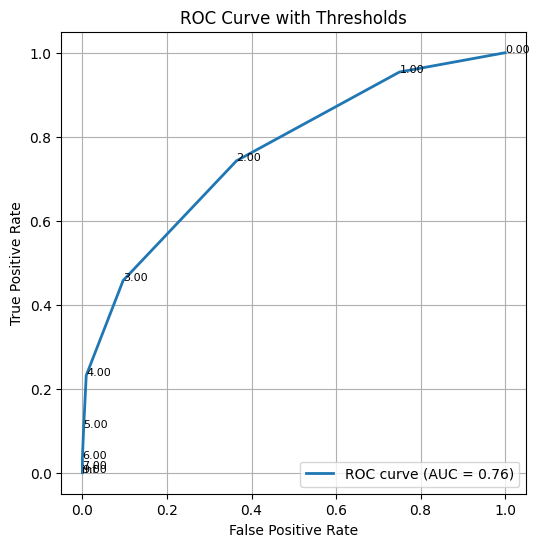

In [4]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

for num_f in numerical:
    sc=roc_auc_score(y_train, df_train[num_f])
    if sc < 0.5:
        sc = roc_auc_score(-df_train[num_f], y_train)
    print(num_f, sc)

fpr, tpr, thresholds = roc_curve(y_train, df_train.number_of_courses_viewed)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')

# Annotate a few thresholds
for i in range(0, len(thresholds), max(1, len(thresholds)//10)):
    plt.text(fpr[i], tpr[i], f'{thresholds[i]:.2f}', fontsize=8)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Thresholds')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


# Q2

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

dv = DictVectorizer(sparse=False)
dv.fit(df_train.to_dict(orient="records"))
prep = lambda d: pd.DataFrame(dv.transform(d.to_dict(orient="records")), columns=dv.get_feature_names_out())

df_X_train = prep(df_train)
df_X_val = prep(df_val)


model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(df_X_train, y_train)
y_probs = model.predict_proba(df_X_val)[:,1]

print(roc_auc_score(y_val, y_probs))
df_X_train.head()

0.8171316268814112


,annual_income,employment_status=NA,employment_status=employed,employment_status=self_employed,employment_status=student,employment_status=unemployed,industry=NA,industry=education,industry=finance,industry=healthcare,...,lead_source=social_media,location=NA,location=africa,location=asia,location=australia,location=europe,location=middle_east,location=north_america,location=south_america,number_of_courses_viewed
0,95543.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0
1,54924.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,77352.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0
3,34600.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
4,43615.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


#  Q3 Q4

PRE: 0.6693877551020408 REC: 0.9590643274853801 F1: 0.7884615384615384


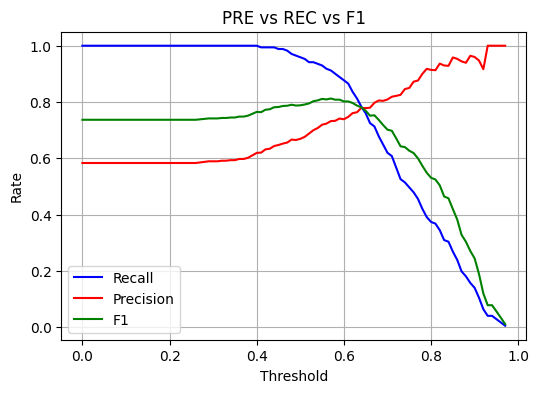

PRE REC intersection at t 0.64
Max F1 at t: 0.5700000000000001


In [14]:
# F1

def get_pre_rec(probs, y, threshold):
    y_pred = np.array([p>=threshold for p in probs])
    
    tp =(y_pred & y).sum() # ypred = 1, y_test = 1
    fp =(y_pred & ~y).sum()# ypred = 1, y_test = 0
    fn =(~y_pred & y).sum() # ypred = 0, y_test = 1

    # print(tp, fp, fn)

    if tp+fp == 0:
        return (np.nan,)*4

    pre = tp/(tp+fp) # % correctly guessed +s among all guesses
    rec = tp/(tp+fn) # % of correctly guessed +s among all +s
    f1 = 2*pre*rec/(pre+rec)
    return pre, rec, f1, threshold 

pre, rec, f1, t = get_pre_rec(y_probs, y_val, .5)
print("PRE:",pre,"REC:",rec, "F1:", f1)

Ts = np.linspace(0,1,101)

g = lambda t: get_pre_rec(y_probs, y_val, t)
plot_df = pd.DataFrame(np.array(list(map(g,Ts))),columns=["PRE","REC", "F1", "t"])

plt.figure(figsize=(6, 4))
plt.plot(Ts, plot_df['REC'], label='Recall', color='blue')
plt.plot(Ts, plot_df['PRE'], label='Precision', color='red')
plt.plot(Ts, plot_df['F1'], label='F1', color='green')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.title('PRE vs REC vs F1')
plt.legend()
plt.grid()
plt.show()

print("PRE REC intersection at t", plot_df.iloc[(plot_df["PRE"]-plot_df["REC"]).abs().idxmin()].t)
print("Max F1 at t:",plot_df.iloc[plot_df['F1'].idxmax()].t)


# Q5

In [7]:
from sklearn.model_selection import KFold



kf = KFold(n_splits=5, shuffle=True, random_state=1)
aucs = []
for train_idx, val_idx in kf.split(df_train_val):
    dv = DictVectorizer(sparse=False)
    X_train_batch, Y_train_batch = dv.fit_transform(df_train_val.iloc[train_idx].to_dict(orient="records")), y_train_val.iloc[train_idx]
    X_val_batch, Y_val_batch = dv.transform(df_train_val.iloc[val_idx].to_dict(orient="records")), y_train_val.iloc[val_idx]
    m = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    m.fit(X_train_batch, Y_train_batch)
    aucs.append(roc_auc_score(Y_val_batch,m.predict_proba(X_val_batch)[:,1]))

np.mean(aucs), np.std(aucs)

(np.float64(0.8221089148573075), np.float64(0.03580711942905165))

# Q6

In [8]:
C = [0.000001, 0.001, 1]

for c in C:
    aucs = []
    for train_idx, val_idx in kf.split(df_train_val):
        dv = DictVectorizer(sparse=False)
        X_train_batch, Y_train_batch = dv.fit_transform(df_train_val.iloc[train_idx].to_dict(orient="records")), y_train_val.iloc[train_idx]
        X_val_batch, Y_val_batch = dv.transform(df_train_val.iloc[val_idx].to_dict(orient="records")), y_train_val.iloc[val_idx]
        m = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
        m.fit(X_train_batch, Y_train_batch)
        aucs.append(roc_auc_score(Y_val_batch, m.predict_proba(X_val_batch)[:,1]))
    
    print(c, np.mean(aucs), np.std(aucs))
    

1e-06 0.560207852870275 0.023798316620649906
0.001 0.8668780317675395 0.028746230508215103
1 0.8221089148573075 0.03580711942905165
